# Masked Diffusion Language Models (MDLM) from First Principles

* This notebook breaks down discrete denoising diffusion modeling to its core components
  * It's a minimal version that captures the essential ideas without the complexity of production code.

## Core Concepts

1. **Forward Process**: Gradually corrupt discrete tokens by replacing them with [MASK] tokens
2. **Backward Process**: Learn to predict the original tokens from masked sequences
3. **Noise Schedule**: Control how quickly we add noise (masking rate over time)
4. **Sampling**: Generate new sequences by iteratively denoising from pure noise

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Simple vocab
vocab_size = 10  # digits 0-9
mask_token = vocab_size  # token 10 is our [MASK]
sequence_length = 8

# Dataset that contains simple patterns
def generate_toy_data(n_samples=1000):
    data = []
    for _ in range(n_samples):
        pattern_type = np.random.choice(['ascending', 'descending', 'repeated', 'random'])
        
        if pattern_type == 'ascending':
            start = np.random.randint(0, vocab_size - sequence_length + 1)
            seq = list(range(start, start + sequence_length))
        elif pattern_type == 'descending':
            start = np.random.randint(sequence_length - 1, vocab_size)
            seq = list(range(start, start - sequence_length, -1))
        elif pattern_type == 'repeated':
            pattern = np.random.randint(0, vocab_size, size=2)
            seq = list(pattern) * (sequence_length // 2)
        else:
            seq = np.random.randint(0, vocab_size, size=sequence_length).tolist()
        
        data.append(seq)
    
    return torch.tensor(data)


train_data = generate_toy_data(1000)
print("Sample sequences:")
for i in range(5):
    print(train_data[i].tolist())

Sample sequences:
[3, 7, 3, 7, 3, 7, 3, 7]
[0, 1, 2, 3, 4, 5, 6, 7]
[9, 2, 9, 2, 9, 2, 9, 2]
[7, 4, 7, 4, 7, 4, 7, 4]
[7, 7, 2, 5, 4, 1, 7, 5]


In [3]:
print("Sample sequences:")
for i in range(15, 25):
    print(train_data[i].tolist())

Sample sequences:
[1, 2, 3, 4, 5, 6, 7, 8]
[6, 7, 2, 0, 3, 1, 7, 3]
[8, 7, 6, 5, 4, 3, 2, 1]
[8, 7, 6, 5, 4, 3, 2, 1]
[8, 7, 6, 5, 4, 3, 2, 1]
[2, 3, 4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4, 3, 2, 1]
[1, 9, 3, 7, 6, 8, 7, 4]
[1, 4, 7, 9, 8, 8, 0, 8]
[8, 7, 8, 7, 8, 7, 8, 7]


## Step 2: Noise Schedule

The noise schedule determines how quickly we corrupt the data. In discrete diffusion, this controls the probability of masking tokens at each timestep.


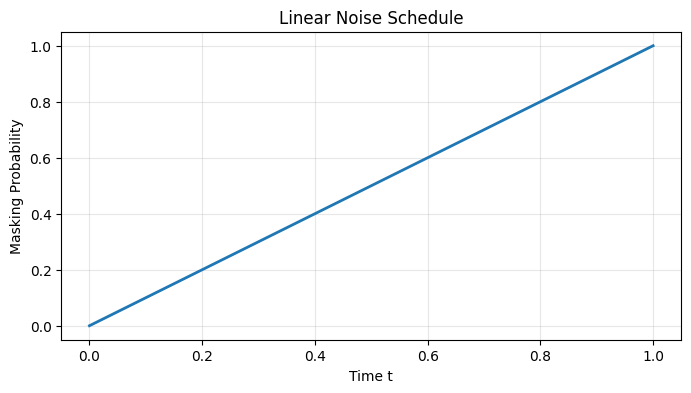

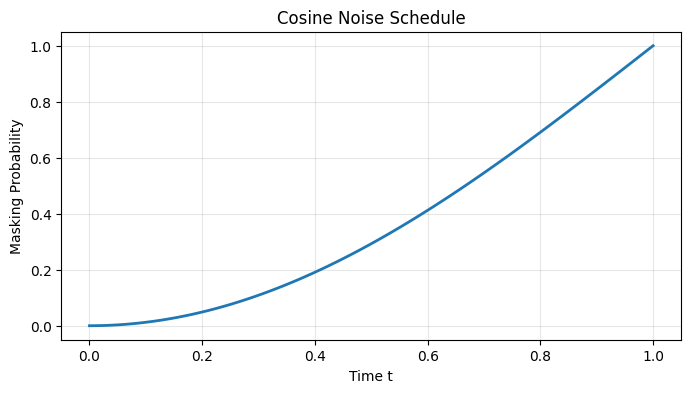

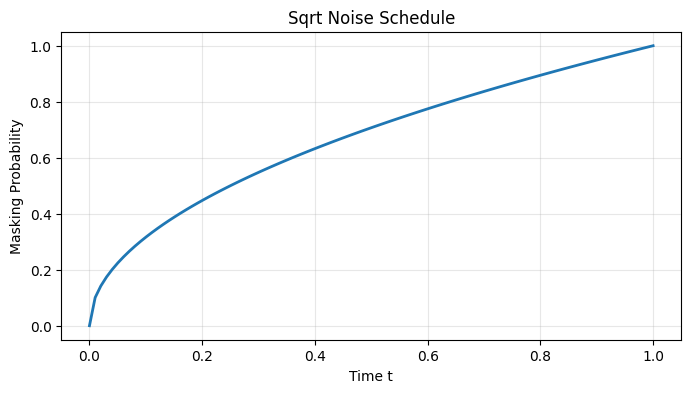

In [4]:
class NoiseSchedule:
    """Simple linear noise schedule for discrete diffusion."""
    
    def __init__(self, T=1000, schedule_type='linear'):
        self.T = T
        self.schedule_type = schedule_type
        
    def get_noise_level(self, t):
        """Get the cumulative noise level (masking probability) at time t.
            t: timestep in [0, 1] where 0 is clean data and 1 is fully noised
        
            Returns the probability of a token being masked
        """
        if self.schedule_type == 'linear':
            # Linear schedule: probability increases linearly with time
            return t
        elif self.schedule_type == 'cosine':
            # Cosine schedule: slower at beginning and end
            return 1 - np.cos(t * np.pi / 2)
        elif self.schedule_type == 'sqrt':
            # Square root schedule: faster initial corruption
            return np.sqrt(t)
    
    def visualize(self):
        t_values = np.linspace(0, 1, 100)
        noise_values = [self.get_noise_level(t) for t in t_values]
        
        plt.figure(figsize=(8, 4))
        plt.plot(t_values, noise_values, linewidth=2)
        plt.xlabel('Time t')
        plt.ylabel('Masking Probability')
        plt.title(f'{self.schedule_type.capitalize()} Noise Schedule')
        plt.grid(True, alpha=0.3)
        plt.show()

# Visualize different noise schedules
for schedule_type in ['linear', 'cosine', 'sqrt']:
    noise_schedule = NoiseSchedule(schedule_type=schedule_type)
    noise_schedule.visualize()

## Step 3: Forward Diffusion Process

The forward process corrupts data by randomly masking tokens according to the noise schedule.

In [5]:
noise_schedule = NoiseSchedule(schedule_type='cosine')

noise_schedule.get_noise_level(0.8)

0.6909830056250525

In [6]:
mask_prob = torch.full((1, 8), 0.69)
mask_prob

tensor([[0.6900, 0.6900, 0.6900, 0.6900, 0.6900, 0.6900, 0.6900, 0.6900]])

In [7]:
torch.rand(1, 8)

tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936]])

In [8]:
mask = torch.rand(1, 8) < mask_prob
mask

tensor([[False,  True, False,  True, False,  True, False,  True]])

In [9]:
def forward_diffusion(x0, t, noise_schedule):
    """Apply forward diffusion process to clean data.
    
    x0: Original clean sequences [batch_size, seq_len]
    t: Timestep(s) in [0, 1] [batch_size] or scalar
    noise_schedule: NoiseSchedule instance

    Returns:
        xt: Corrupted sequences
        mask: Boolean mask indicating which positions were corrupted
    """
    batch_size, seq_len = x0.shape
    
    if isinstance(t, torch.Tensor):
        mask_prob = torch.tensor([noise_schedule.get_noise_level(ti.item()) for ti in t])
        mask_prob = mask_prob.view(-1, 1).expand(-1, seq_len)
    else:
        mask_prob = noise_schedule.get_noise_level(t)
        mask_prob = torch.full((batch_size, seq_len), mask_prob)
    
    mask = torch.rand(batch_size, seq_len) < mask_prob
    
    xt = x0.clone()
    xt[mask] = mask_token
    
    return xt, mask

sample_seq = train_data[0:1]  # Take one sequence
noise_schedule = NoiseSchedule(schedule_type='cosine')

print("Original sequence:", sample_seq[0].tolist())
print("\nForward diffusion process:")

for t in [0.0, 0.25, 0.5, 0.75, 1.0]:
    xt, mask = forward_diffusion(sample_seq, t, noise_schedule)
    print(f"t={t:.2f}: {xt[0].tolist()} (masked positions: {mask[0].nonzero().squeeze().tolist()})")

Original sequence: [3, 7, 3, 7, 3, 7, 3, 7]

Forward diffusion process:
t=0.00: [3, 7, 3, 7, 3, 7, 3, 7] (masked positions: [])
t=0.25: [3, 7, 3, 7, 3, 10, 3, 10] (masked positions: [5, 7])
t=0.50: [3, 7, 3, 7, 3, 7, 3, 7] (masked positions: [])
t=0.75: [3, 10, 3, 7, 3, 10, 3, 10] (masked positions: [1, 5, 7])
t=1.00: [10, 10, 10, 10, 10, 10, 10, 10] (masked positions: [0, 1, 2, 3, 4, 5, 6, 7])


## Step 4: Denoising Model

The core of diffusion models is learning to reverse the corruption process. We'll build a simple transformer that predicts the original tokens from masked sequences.

In [10]:
vocab_size

10

In [11]:
token_embedding = nn.Embedding(4, 16)

embeds = token_embedding(torch.tensor([[0,3]]))
print(embeds.shape)
embeds


torch.Size([1, 2, 16])


tensor([[[-0.8371, -0.9224,  1.8113,  0.1606,  0.3672,  0.1754,  1.3852,
          -0.4459, -1.2024,  0.7078, -1.0759,  0.5357,  1.1754,  0.5612,
          -0.4527, -0.7718],
         [-0.6788,  0.5743,  0.1877, -0.3576, -0.3165,  0.5886, -0.8905,
           0.4098, -0.9864,  0.1233,  0.3499,  0.6173, -0.1693,  0.2332,
           4.0356,  1.2795]]], grad_fn=<EmbeddingBackward0>)

In [12]:
positions = torch.arange(8, device='cpu').expand(1, -1)
positions

tensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [13]:
pos_embeddings =  nn.Embedding(8, 16)
pos_embeddings(positions)

tensor([[[ 1.0311, -0.7048,  1.0131, -0.3308,  0.5177,  0.3878, -0.5797,
          -0.1691, -0.5733,  0.5069, -0.4752, -0.4920,  0.2704, -0.5628,
           0.6793,  0.4405],
         [-0.3609, -0.0606,  0.0733,  0.8187,  1.4805,  0.3449, -1.4241,
          -0.1163,  0.2176, -0.0467, -1.4335, -0.5665, -0.4253,  0.2625,
          -1.4391,  0.5214],
         [ 1.0414, -0.3997, -2.2933,  0.4976, -0.4257, -1.3371, -0.1933,
           0.6526, -0.3063, -0.3302, -0.9808,  0.1947, -1.6535,  0.6814,
           1.4611, -0.3098],
         [ 0.9633, -0.3095,  0.5712,  1.1179, -1.2956,  0.0503, -0.5855,
          -0.3900,  0.9812, -0.6401, -0.4908,  0.2080, -1.1586, -0.9637,
          -0.3750,  0.8033],
         [ 0.7165,  1.5335, -1.4510, -0.7861, -0.9563, -1.2476, -0.7499,
          -0.5922, -1.5326, -0.7251,  0.4664,  0.6667, -0.0439,  0.2368,
          -0.7061, -0.7169],
         [-0.1593, -0.4249,  0.9442, -0.1849,  1.0608,  0.2083, -0.5778,
           0.3255,  0.2618, -0.7599, -2.0461, -1.529

In [14]:
time_embedding = nn.Sequential(
            nn.Linear(1, 16),
            nn.SiLU(),
            nn.Linear(16, 16)
)

time_embedding(torch.tensor([[0.25]]))

tensor([[-0.2290, -0.0006, -0.2174,  0.1970, -0.5486, -0.0645, -0.0550,  0.2129,
          0.0434, -0.0326,  0.2632,  0.3009,  0.2531,  0.1929,  0.0880,  0.4781]],
       grad_fn=<AddmmBackward0>)

In [15]:
time_embedding(torch.tensor([[0.25]])).unsqueeze(1).expand(-1, 8, -1)

tensor([[[-0.2290, -0.0006, -0.2174,  0.1970, -0.5486, -0.0645, -0.0550,
           0.2129,  0.0434, -0.0326,  0.2632,  0.3009,  0.2531,  0.1929,
           0.0880,  0.4781],
         [-0.2290, -0.0006, -0.2174,  0.1970, -0.5486, -0.0645, -0.0550,
           0.2129,  0.0434, -0.0326,  0.2632,  0.3009,  0.2531,  0.1929,
           0.0880,  0.4781],
         [-0.2290, -0.0006, -0.2174,  0.1970, -0.5486, -0.0645, -0.0550,
           0.2129,  0.0434, -0.0326,  0.2632,  0.3009,  0.2531,  0.1929,
           0.0880,  0.4781],
         [-0.2290, -0.0006, -0.2174,  0.1970, -0.5486, -0.0645, -0.0550,
           0.2129,  0.0434, -0.0326,  0.2632,  0.3009,  0.2531,  0.1929,
           0.0880,  0.4781],
         [-0.2290, -0.0006, -0.2174,  0.1970, -0.5486, -0.0645, -0.0550,
           0.2129,  0.0434, -0.0326,  0.2632,  0.3009,  0.2531,  0.1929,
           0.0880,  0.4781],
         [-0.2290, -0.0006, -0.2174,  0.1970, -0.5486, -0.0645, -0.0550,
           0.2129,  0.0434, -0.0326,  0.2632,  0.300

Why Can't We Use Regular Embeddings (discrete time step [0, 1, 2, .. T])?
```
some_embedding = nn.Embedding(num_embeddings=10, embedding_dim=4)
time_values = torch.tensor([0.0, 0.137, 0.842, 1.0])

# some_embedding(time_values)  # Naturally can't do this, as 
```

* time embedding can be implemented using by discretizing conntinous time in buckets
* It's not the correct way to do it as we lose information.


In [16]:
n_timesteps = 10

# Convert continuous time to discrete buckets
continuous_time = torch.tensor([0.0, 0.25, 0.5, 0.75, 1.0])
discrete_indices = (continuous_time * (n_timesteps - 1)).int()
print(continuous_time)
print(discrete_indices)



tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
tensor([0, 2, 4, 6, 9], dtype=torch.int32)


In [17]:
discrete_time_embedding = nn.Embedding(n_timesteps, embedding_dim=4)
discrete_time_embedding

Embedding(10, 4)

In [18]:
discrete_emb = discrete_time_embedding(discrete_indices)
discrete_emb


tensor([[ 0.5163,  1.6060, -0.9815,  0.5361],
        [-0.7983, -0.2648, -0.1666,  0.2518],
        [-0.1739,  0.0299, -0.0140, -0.0102],
        [ 0.0613,  0.0853,  0.7481, -0.1636],
        [ 0.6378,  0.1598,  1.7698,  0.6268]], grad_fn=<EmbeddingBackward0>)

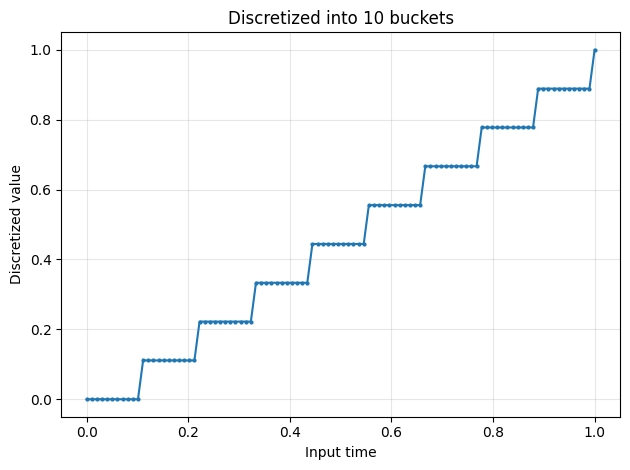

In [19]:
times_dense = torch.linspace(0, 1, 100)
n_buckets = 10
discrete_indices = (times_dense * (n_buckets - 1)).long()


plt.plot(times_dense, discrete_indices.float() / (n_buckets - 1), 'o-', markersize=2)
plt.xlabel('Input time')
plt.ylabel('Discretized value')
plt.title(f'Discretized into {n_buckets} buckets')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


* Multiple continuous values map to same discrete bucket.
  * Example: t=0.15 and t=0.18 both map to bucket at pos 1
  
* Use a continous MLP isntead to embed continuous values  


In [20]:
class ContinuousTimeEmbedding(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, output_dim),
            nn.SiLU(),  # Smooth activation
            nn.Linear(output_dim, output_dim)
        )
    
    def forward(self, t):
        # t should have shape [..., 1]
        return self.mlp(t)

time_embed = ContinuousTimeEmbedding(output_dim=16)
continuous_times = torch.tensor([[0.0], [0.137], [0.5], [0.842], [1.0]])
embeddings = time_embed(continuous_times)
print(f"Input shape: {continuous_times.shape}")
print(f"Output shape: {embeddings.shape}")

Input shape: torch.Size([5, 1])
Output shape: torch.Size([5, 16])


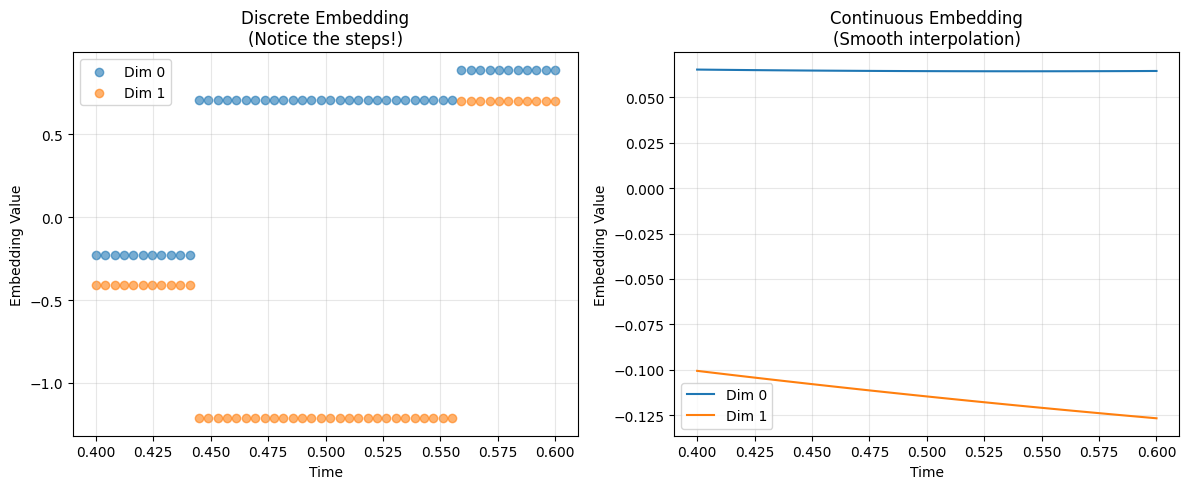

In [21]:
def compare_discrete_vs_continuous():
    # Setup
    n_timesteps = 10
    embed_dim = 2  # Use 2D for easy visualization
    
    discrete_embed = nn.Embedding(n_timesteps, embed_dim)
    continuous_embed = nn.Sequential(
        nn.Linear(1, 8),
        nn.SiLU(),
        nn.Linear(8, embed_dim)
    )
    
    # Dense sampling around a small region
    times = torch.linspace(0.4, 0.6, 50)
    
    # Get embeddings
    discrete_idx = (times * (n_timesteps - 1)).long()
    disc_emb = discrete_embed(discrete_idx)
    cont_emb = continuous_embed(times.unsqueeze(-1))
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Discrete - shows steps
    ax1.scatter(times, disc_emb[:, 0].detach(), alpha=0.6, label='Dim 0')
    ax1.scatter(times, disc_emb[:, 1].detach(), alpha=0.6, label='Dim 1')
    ax1.set_title('Discrete Embedding\n(Notice the steps!)')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Embedding Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Continuous - smooth
    ax2.plot(times, cont_emb[:, 0].detach(), label='Dim 0')
    ax2.plot(times, cont_emb[:, 1].detach(), label='Dim 1')
    ax2.set_title('Continuous Embedding\n(Smooth interpolation)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Embedding Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

compare_discrete_vs_continuous()

* Other alternatives is sinusoidal. 

* Benefits of continuous approaches
  *  Smooth gradients for training
  * Natural interpolation between time steps
  * Better for sampling (gradual denoising)



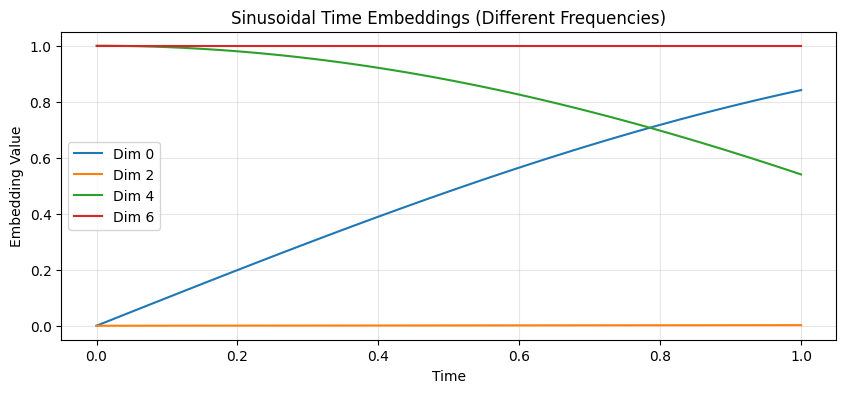

In [22]:
def sinusoidal_time_embedding(t, d_model=16):
    """
    Sinusoidal embedding - similar to positional encoding in Transformers.
    No learnable parameters!
    """
    # Ensure t has batch dimension
    if t.dim() == 1:
        t = t.unsqueeze(-1)
    
    half_dim = d_model // 2
    embeddings = torch.zeros(t.shape[0], d_model)
    
    # Create different frequency bands
    frequencies = torch.exp(
        torch.arange(half_dim) * -(np.log(10000.0) / (half_dim - 1))
    )
    
    # Apply sin to first half, cos to second half
    angles = t * frequencies
    embeddings[:, :half_dim] = torch.sin(angles)
    embeddings[:, half_dim:] = torch.cos(angles)
    
    return embeddings

# Visualize sinusoidal patterns
times = torch.linspace(0, 1, 100)
sin_emb = sinusoidal_time_embedding(times, d_model=8)

plt.figure(figsize=(10, 4))
for i in range(0,8,2):
    plt.plot(times, sin_emb[:, i], label=f'Dim {i}')
plt.xlabel('Time')
plt.ylabel('Embedding Value')
plt.title('Sinusoidal Time Embeddings (Different Frequencies)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [23]:
def test_interpolation():
    # Three adjacent time points
    t1, t2, t3 = 0.50, 0.51, 0.52
    times = torch.tensor([t1, t2, t3])
    
    # Discrete embedding
    n_steps = 10
    discrete_embed = nn.Embedding(n_steps, 2)
    disc_idx = (times * (n_steps - 1)).long()
    disc_emb = discrete_embed(disc_idx)
    
    # Continuous embedding  
    continuous_embed = nn.Sequential(nn.Linear(1, 2))
    cont_emb = continuous_embed(times.unsqueeze(-1))
    
    print("Time values:", times.tolist())
    print("Discrete indices:", disc_idx.tolist())
    print("\nDiscrete embeddings:")
    print(disc_emb.detach().numpy())
    print("\nContinuous embeddings:")
    print(cont_emb.detach().numpy())

test_interpolation()

Time values: [0.5, 0.5099999904632568, 0.5199999809265137]
Discrete indices: [4, 4, 4]

Discrete embeddings:
[[-0.8132007   0.14148217]
 [-0.8132007   0.14148217]
 [-0.8132007   0.14148217]]

Continuous embeddings:
[[-0.64722663 -0.1039741 ]
 [-0.64154273 -0.09842151]
 [-0.63585883 -0.09286891]]


* How does time affect model predictions?


In [24]:
mask_token

10

In [25]:
original = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
masked = original.clone()
masked[0, [2, 5]] = mask_token
print(f"Original: {original[0].tolist()}")
print(f"Masked:   {masked[0].tolist()}") 


Original: [1, 2, 3, 4, 5, 6, 7, 8]
Masked:   [1, 2, 10, 4, 5, 10, 7, 8]


In [26]:
t_tensor = torch.tensor([[0.1]])
logits = model(masked, t_tensor)
logits


NameError: name 'model' is not defined

In [27]:
position = 2 
logits[0, position]

NameError: name 'logits' is not defined

In [ ]:
probs = F.softmax(logits[0, position], dim=-1)
probs


top_probs, top_tokens = probs.topk(3)
top_probs, top_tokens

NameError: name 'logits' is not defined

In [ ]:

print(f"\nTime t={t} (noise level):")

for prob, token in zip(top_probs, top_tokens):
    print(f"  Token {token}: {prob:.3f}")



Time t=1.0 (noise level):


NameError: name 'top_probs' is not defined

In [ ]:
def simple_time_test(model, masked_sequence, position=2):
    model.eval()
    
    times = [0.1, 0.5, 0.9]  # Low, medium, high noise
    
    for t in times:
        t_tensor = torch.tensor([[t]])
        logits = model(masked_sequence, t_tensor)
        probs = F.softmax(logits[0, position], dim=-1)
        
        # Find top 3 predictions
        top_probs, top_tokens = probs.topk(3)
        print(f"\nTime t={t} (noise level):")
        for prob, token in zip(top_probs, top_tokens):
            print(f"  Token {token}: {prob:.3f}")
simple_time_test(model, masked, position=2)            


NameError: name 'model' is not defined

The probs for Token 2 are the same across noise, but the idea is that on a trained model, we expect
- t=0.1 (low noise): "I'm pretty sure what was here"
- t=0.5 (medium noise): "Could be a few things"  
- t=0.9 (high noise): "Could be almost anything"

Something like the following:

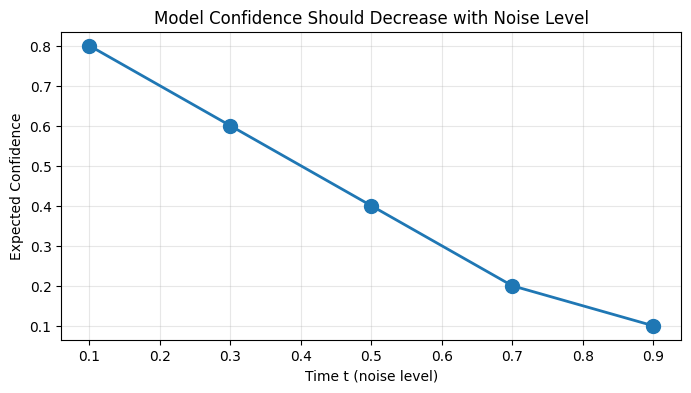

In [ ]:
# This  won't work on a model that's not well trained yet

def plot_confidence_vs_time():
    times = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    # Simulated max probabilities (what we expect)
    expected_confidence = [0.8, 0.6, 0.4, 0.2, 0.1]
    
    plt.figure(figsize=(8, 4))
    plt.plot(times, expected_confidence, 'o-', linewidth=2, markersize=10)
    plt.xlabel('Time t (noise level)')
    plt.ylabel('Expected Confidence')
    plt.title('Model Confidence Should Decrease with Noise Level')
    plt.grid(True, alpha=0.3)
    plt.show()
    
plot_confidence_vs_time()



### Key Takeaways:

1. **What**: We mask some positions and see how the model's predictions change with different time values

2. **Why**: Time tells the model how noisy/corrupted the input is:
   - Low t (≈0) = "This is almost clean, be confident"
   - High t (≈1) = "This is very noisy, be uncertain"

3. **Expected Behavior**:
   - At t≈0: Sharp distribution (high confidence on correct token)
   - At t≈1: Flat distribution (uncertain about all tokens)

4. **Why It Matters**: During sampling, we start at t=1 (all masked) and go to t=0. The model needs to gradually become more confident as we denoise.

The original code just does this for multiple positions at once and creates a grid of plots. The core idea is simple: **time conditioning teaches the model to adjust its confidence based on the noise level**.

I need to revisit this after model is trained.

* Why do we use SiLU Activation?




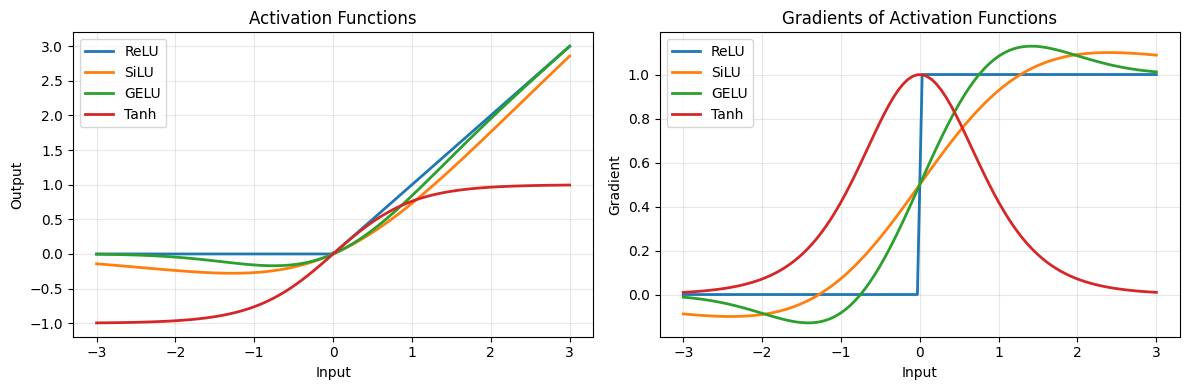

In [28]:
def compare_activations():
    x = torch.linspace(-3, 3, 100)
    
    # Different activation functions
    relu = F.relu(x)
    silu = F.silu(x)  # x * sigmoid(x)
    gelu = F.gelu(x)
    tanh = torch.tanh(x)
    
    # Plot comparisons
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot activations
    axes[0].plot(x, relu, label='ReLU', linewidth=2)
    axes[0].plot(x, silu, label='SiLU', linewidth=2)
    axes[0].plot(x, gelu, label='GELU', linewidth=2)
    axes[0].plot(x, tanh, label='Tanh', linewidth=2)
    axes[0].set_xlabel('Input')
    axes[0].set_ylabel('Output')
    axes[0].set_title('Activation Functions')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot derivatives (gradients)
    x.requires_grad = True
    
    # Compute gradients
    activations = [('ReLU', F.relu), ('SiLU', F.silu), 
                  ('GELU', F.gelu), ('Tanh', torch.tanh)]
    
    for name, act_fn in activations:
        y = act_fn(x)
        grad = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
        axes[1].plot(x.detach(), grad.detach(), label=name, linewidth=2)
    
    axes[1].set_xlabel('Input')
    axes[1].set_ylabel('Gradient')
    axes[1].set_title('Gradients of Activation Functions')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

compare_activations()

### Why SiLU for time embeddings?
1. Smooth: Unlike ReLU, SiLU is smooth everywhere
2. Non-zero gradients: Allows learning even for negative inputs
3. Self-gated: The x*sigmoid(x) form provides adaptive gating
  * Negative inputs → Small gate → Get suppressed
  * Positive inputs → Large gate → Pass through mostly unchanged
  * Near zero → Medium gate → Partially reduced
4. Proven effectiveness: Works well in practice for continuous embeddings


In [ ]:
def silu(x):
    return x * torch.sigmoid(x)

test_values = torch.tensor([-5.0, -2.0, 0.0, 2.0, 5.0])
results = silu(test_values)

print("Input → Output")
print("-" * 20)
for x, y in zip(test_values, results):
    print(f"{x:5.1f} → {y:5.2f}")

Input → Output
--------------------
 -5.0 → -0.03
 -2.0 → -0.24
  0.0 →  0.00
  2.0 →  1.76
  5.0 →  4.97


### Time Embeddings in Discrete Diffusion

The time embedding is crucial because it tells the model "how noisy is this input?". Key points:

1. **Continuous vs Discrete**: We use an MLP instead of `nn.Embedding` because time `t` is continuous (0.0 to 1.0), not discrete indices

2. **Architecture**: The two-layer MLP with SiLU activation provides:
   - Smooth interpolation between time values
   - Non-linear transformation to capture complex relationships
   - Good gradient flow for stable training

3. **Effect on Predictions**: The model learns to:
   - Be more uncertain at high noise levels (t ≈ 1)
     - Early exploration. 
   - Be more confident at low noise levels (t ≈ 0)
     - Converge to high-quality samples
   - Adjust its predictions based on expected corruption level

4. **Why it matters**: During sampling, we gradually decrease t from 1 to 0, and the model needs to smoothly transition its behavior from "exploratory" (high noise) to "precise" (low noise).
```

In [29]:
class SimpleDenoisingTransformer(nn.Module):
    
    def __init__(self, vocab_size, d_model=128, n_heads=4, n_layers=2, max_len=100):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        self.token_embedding = nn.Embedding(vocab_size + 1, d_model)
        
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
        self.time_embedding = nn.Sequential(
            nn.Linear(1, d_model),
            nn.SiLU(),
            nn.Linear(d_model, d_model)
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        self.output_proj = nn.Linear(d_model, vocab_size)
        
    def forward(self, x, t):
        """Forward pass.
        
        x: Masked sequences [batch_size, seq_len]
        t: Timestep [batch_size, 1]
        
        Returns:
            Logits for each position [batch_size, seq_len, vocab_size]
        """
        batch_size, seq_len = x.shape
        
        # Token embeddings
        token_emb = self.token_embedding(x)
        
        # Position embeddings
        positions = torch.arange(seq_len, device=x.device).expand(batch_size, -1)
        pos_emb = self.pos_embedding(positions)
        
        # Time embeddings (broadcast to all positions)
        time_emb = self.time_embedding(t).unsqueeze(1).expand(-1, seq_len, -1)
        
        h = token_emb + pos_emb + time_emb
        
        h = self.transformer(h)
        
        logits = self.output_proj(h)
        
        return logits

model = SimpleDenoisingTransformer(vocab_size=vocab_size)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 428,810


## Step 5: Training Loss

The key insight of discrete diffusion is that we train the model to predict the original tokens only at masked positions.

In [31]:
x0 = train_data[:3]
batch_size = x0.shape[0]

t = torch.rand(batch_size, 1)

xt, mask = forward_diffusion(x0, t.squeeze(), noise_schedule)
xt, mask

(tensor([[ 3,  7,  3,  7,  3, 10,  3,  7],
         [ 0,  1,  2, 10, 10,  5,  6,  7],
         [10,  2,  9,  2,  9, 10,  9,  2]]),
 tensor([[False, False, False, False, False,  True, False, False],
         [False, False, False,  True,  True, False, False, False],
         [ True, False, False, False, False,  True, False, False]]))

In [32]:
logits = model(xt, t)
logits.shape

torch.Size([3, 8, 10])

In [33]:
mask

tensor([[False, False, False, False, False,  True, False, False],
        [False, False, False,  True,  True, False, False, False],
        [ True, False, False, False, False,  True, False, False]])

In [34]:
x0

tensor([[3, 7, 3, 7, 3, 7, 3, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [9, 2, 9, 2, 9, 2, 9, 2]])

In [35]:
x0[mask].shape, x0[mask]

(torch.Size([5]), tensor([7, 3, 4, 9, 2]))

In [36]:
logits[mask].shape, logits[mask]

(torch.Size([5, 10]),
 tensor([[ 0.4826, -0.6602, -0.2757,  0.6274, -0.9268, -0.6197, -0.0476, -0.1012,
           0.5570,  0.4182],
         [ 0.1634, -1.1443,  0.4175,  0.1717, -0.9762,  0.2351, -0.4500, -0.5907,
           0.4806, -0.5284],
         [ 0.0360, -0.9281, -0.1254,  0.6559, -0.9352, -0.2071, -0.6747, -0.3665,
           0.5989, -0.3577],
         [ 0.9589, -1.1517,  0.1552,  0.6266, -1.1317, -0.9832,  0.1715, -0.0521,
           0.1236,  0.2501],
         [ 0.3335, -0.8955, -0.0896,  0.2955, -1.1847, -0.4491,  0.1042, -0.3488,
           0.8152,  0.3092]], grad_fn=<IndexBackward0>))

In [37]:
def compute_loss(model, x0, noise_schedule):
    """Compute the discrete diffusion training loss.
    
    Args:
        model: Denoising model
        x0: Clean sequences [batch_size, seq_len]
        noise_schedule: NoiseSchedule instance
    
    Returns:
        Loss value
    """
    batch_size = x0.shape[0]
    
    t = torch.rand(batch_size, 1)
    
    xt, mask = forward_diffusion(x0, t.squeeze(), noise_schedule)
    
    logits = model(xt, t)
    
    loss = F.cross_entropy(
        logits[mask],      
        x0[mask],          
        reduction='mean'
    )
    
    return loss, (mask.sum().item() / mask.numel())  # Also return mask rate for monitoring

torch.manual_seed(42)
np.random.seed(42)

with torch.no_grad():
    loss, mask_rate = compute_loss(model, train_data[:32], noise_schedule)
    print(f"Initial loss: {loss:.4f}, Mask rate: {mask_rate:.2%}")

Initial loss: 2.5225, Mask rate: 43.75%


### proceed with the training

In [ ]:
def train_model(model, data, noise_schedule, n_epochs=500, batch_size=64, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    for epoch in range(n_epochs):
        epoch_losses = []
        
        perm = torch.randperm(len(data))
        
        for i in range(0, len(data), batch_size):
            batch_idx = perm[i:i+batch_size]
            batch = data[batch_idx]
            
            loss, mask_rate = compute_loss(model, batch, noise_schedule)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    
    return losses

model = SimpleDenoisingTransformer(vocab_size=vocab_size)

losses = train_model(model, train_data, noise_schedule, n_epochs=500)

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

Epoch 50/500, Loss: 1.3309


In [ ]:
original = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
masked = original.clone()
masked[0, [2, 5]] = mask_token
simple_time_test(model, masked, position=2)            


NameError: name 'simple_time_test' is not defined

In [ ]:
original = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
masked = original.clone()
masked[0, [2, 5]] = mask_token
simple_time_test(model, masked, position=2)            




Time t=0.1 (noise level):
  Token 3: 0.997
  Token 4: 0.001
  Token 0: 0.001

Time t=0.5 (noise level):
  Token 3: 0.997
  Token 4: 0.001
  Token 0: 0.000

Time t=0.9 (noise level):
  Token 3: 0.997
  Token 4: 0.001
  Token 0: 0.000
